## Домашнее задание «Сегментация и детекция объектов»

### Задание: *Распознавание рукописного ввода на примере базы MNIST*

Построить классификатор изображений рукописного ввода на базе MNIST. В качестве шаблона в данной работе можно использовать <a href="https://github.com/a4tunado/lectures/blob/master/002/002-digit.ipynb" target="_blank">ipython-ноутбук 002-digit.ipynb</a>.

Классификатор предлагается строить на признаках, полученных в результате предобработки изображений, например, гистограммы градиентов (HOG) или результат PCA преобразования.

В качестве модели классификатора можно использовать любую известную Вам модель, за исключением сверточных нейронных сетей.

Критерием качества классификатора является метрика accuracy. Для получения зачета по данной работе, значение метрики accuracy должно быть больше 0.6. Метрика оценивается на тестовой выборке в рамках контеста <a href="https://www.kaggle.com/c/digit-recognizer" target="_blank">Digit Recognizer</a> на Kaggle.

Решение необходимо предоставить в виде ipython-ноутбука с реализацией процесса построения модели и скриншота с финальным результатом на Kaggle.

## Решение

### Загружаем все необходимые библиотеки

In [37]:
%matplotlib inline
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.svm import SVC

In [2]:
print(cv2.__version__)

4.9.0


## Загружаем исходные данные

In [3]:
train = np.loadtxt('./digit-recognizer/train.csv', delimiter = ',', skiprows = 1)
test = np.loadtxt('./digit-recognizer/test.csv', delimiter= ',', skiprows = 1)

In [4]:
train.shape, test.shape

((42000, 785), (28000, 784))

In [5]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
test_label = test[:, 0]

# приводим размерность к удобному для обработки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))


In [6]:
train_label.shape, test_img.shape

((42000,), (28000, 28, 28))

## Визуализируем исходные данные

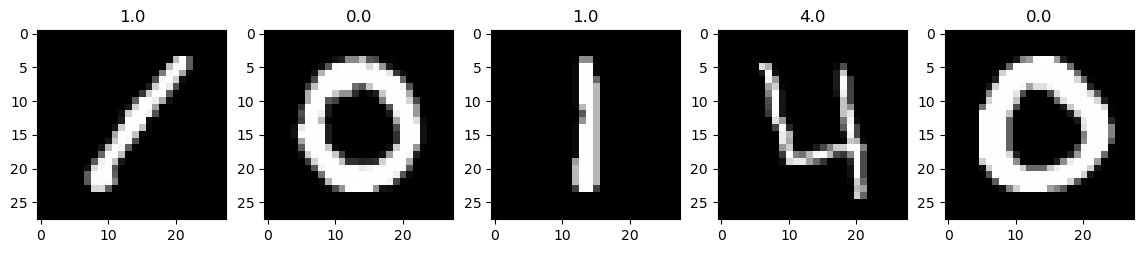

In [7]:
fig = plt.figure(figsize = (20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap = 'gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Задаем параметры для вычисления дескриптора

In [8]:
winSize = (28,28)
blockSize = (14,14)
blockStride = (14,14)
cellSize = (7,7)
nbins = 9
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 0
nlevels = 64

hog = cv2.HOGDescriptor(winSize,
                        blockSize,
                        blockStride,
                        cellSize,
                        nbins,
                        derivAperture,
                        winSigma,
                        histogramNormType,
                        L2HysThreshold,
                        gammaCorrection,
                        nlevels)

In [9]:
# Вычисления гистограммы ориентированных градиентов (HOG) 

train_hist = np.zeros((len(train_img), 144))
for i in range(len(train_img)):
    descriptor = hog.compute(np.uint8(train_img[i]))
    train_hist[i] = descriptor

test_hist = np.zeros((len(test_img), 144))
for i in range(len(test_img)):
    descriptor = hog.compute(np.uint8(test_img[i]))
    test_hist[i] = descriptor

In [10]:
train_hist.shape, test_hist.shape

((42000, 144), (28000, 144))

## Разбиваем выборку на обучение и валидацию

In [11]:
y_train, y_val, x_train, x_val = train_test_split(train_label, train_hist, test_size=0.2,random_state = 0)


### Нормируем вектор гистограммы

In [12]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

### 1. Модель логистическая регрессия

In [13]:
lr_hd = LogisticRegression(random_state = 0, max_iter = 300).fit(x_train, y_train)
prediction_lr = lr_hd.predict(x_val)

In [14]:
print('Accuracy: %s' % accuracy_score(y_val, prediction_lr))

Accuracy: 0.9665476190476191


In [15]:
print(classification_report(y_val, prediction_lr))

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       813
         1.0       0.98      0.98      0.98       961
         2.0       0.96      0.98      0.97       860
         3.0       0.97      0.96      0.97       863
         4.0       0.97      0.95      0.96       827
         5.0       0.98      0.98      0.98       756
         6.0       0.98      0.99      0.98       841
         7.0       0.95      0.95      0.95       899
         8.0       0.95      0.96      0.96       768
         9.0       0.94      0.94      0.94       812

    accuracy                           0.97      8400
   macro avg       0.97      0.97      0.97      8400
weighted avg       0.97      0.97      0.97      8400



In [16]:
print(confusion_matrix(y_val, prediction_lr))

[[800   2   3   1   2   0   2   0   2   1]
 [  0 939   8   0   4   0   1   4   5   0]
 [  2   2 841   4   2   0   0   2   6   1]
 [  2   1   7 830   1   4   0   9   5   4]
 [  0   6   2   0 787   1   6   8   4  13]
 [  0   1   0   6   0 738   3   1   5   2]
 [  0   0   0   0   5   3 830   0   2   1]
 [  2   3  12   0   4   0   0 854   3  21]
 [  7   2   2   7   2   2   4   3 734   5]
 [  2   2   1   8   7   2   1  20   3 766]]


In [17]:
# Предсказания на тестовых данных
prediction_lr_test = np.zeros(len(test_img), np.uint8)
for i in range(len(test_img)):
    prediction_lr_test[i] = lr_hd.predict([test_hist[i]])

### Визуализируем предсказания

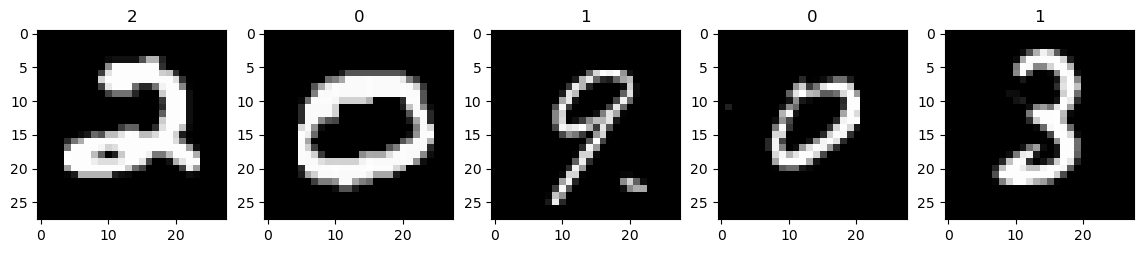

In [18]:
fig = plt.figure(figsize = (20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap = 'gray');
    subplot.set_title('%s' % prediction_lr_test[i - 1]);

In [19]:
with open('submit_lr.csv', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(prediction_lr_test, 1):
        dst.write('%s,%s\n' % (i, p))

![score](submit_lr.png) \
После загрузки в Kaggle score = 0.49557, что не достаточно по условию задачи. Будем рассматривать другие модели.

### 2. Модель классификации Random Forest

In [20]:
rfs_hd = RandomForestClassifier(n_estimators = 200, random_state = 0).fit(x_train, y_train)
prediction_rfs = rfs_hd.predict(x_val)




In [21]:
print('Accuracy: %s' % accuracy_score(y_val, prediction_rfs))

Accuracy: 0.9691666666666666


In [22]:
print(classification_report(y_val, prediction_rfs))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       813
         1.0       0.99      0.98      0.98       961
         2.0       0.94      0.98      0.96       860
         3.0       0.97      0.96      0.96       863
         4.0       0.98      0.97      0.97       827
         5.0       0.98      0.96      0.97       756
         6.0       0.98      0.99      0.98       841
         7.0       0.95      0.96      0.96       899
         8.0       0.96      0.96      0.96       768
         9.0       0.96      0.94      0.95       812

    accuracy                           0.97      8400
   macro avg       0.97      0.97      0.97      8400
weighted avg       0.97      0.97      0.97      8400



In [23]:
print(confusion_matrix(y_val, prediction_rfs))

[[805   0   2   1   1   0   2   0   1   1]
 [  0 940  11   1   3   0   1   3   2   0]
 [  2   0 842   5   0   0   0   4   7   0]
 [  1   1  12 826   0   5   0   8   6   4]
 [  0   1   3   0 801   0   4   5   3  10]
 [  0   0   0   6   1 728   8   1  10   2]
 [  3   0   3   0   2   4 829   0   0   0]
 [  0   2  12   1   2   1   0 867   2  12]
 [  7   2   8   2   0   3   3   2 739   2]
 [  2   3   2   8   8   1   2  20   2 764]]


In [24]:
# Предсказания на тестовых данных
prediction_rfs_test = np.zeros(len(test_img), np.uint8)
for i in range(len(test_img)):
    prediction_rfs_test[i] = rfs_hd.predict([test_hist[i]])

### Визуализируем предсказания

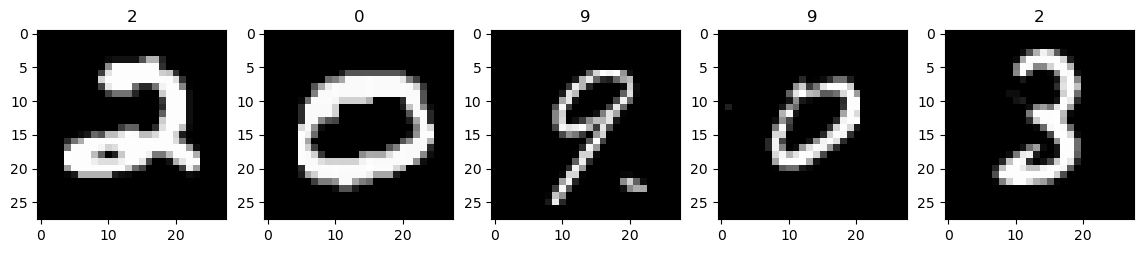

In [25]:
fig = plt.figure(figsize = (20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap = 'gray');
    subplot.set_title('%s' % prediction_rfs_test[i - 1]);

In [26]:
with open('submit_rfs.csv', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(prediction_rfs_test, 1):
        dst.write('%s,%s\n' % (i, p))

![score](submit_rfs.png) \
После загрузки в Kaggle score = 0.88485, что достаточно по условию задачи - значение метрики accuracy должно быть больше 0.6